# Keras dense neural network tutorial
Author: Javier Duarte

# Table of Contents
* [References](#References)
* [Loading libraries](#Loading-libraries)
* [Loading numpy arrays](#Loading-numpy-arrays)
* [Convert to Pandas DataFrame](#Convert-to-Pandas-DataFrame)
* [Plotting inputs](#Plotting-inputs)
* [Dense neural network](#Dense-neural-network)
* [Plotting inputs weighted by prediction](#Plotting-inputs-weighted-by-prediction)

## References
### Data
1. CMS MVA HATS Twiki https://twiki.cern.ch/twiki/bin/view/CMS/MVATechniquesatLPC2017

### Software
1. Keras. https://github.com/fchollet/keras
1. TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems. http://tensorflow.org/
1. Theano: A Python framework for fast computation of mathematical expressions. https://arxiv.org/abs/1605.02688 http://deeplearning.net/software/theano/
1. scikit-learn: Machine Learning in python. http://scikit-learn.org/stable/

## Loading libraries
First we load the relevant libraries.

In [1]:
import os
#os.environ['THEANO_FLAGS'] = 'optimizer=None'
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
import h5py
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using Theano backend.


## Loading numpy arrays
Now we load two different numpy outputs. One corresponding to the VV signal and one corresponding to the gg background.

In [2]:
treename = 'HZZ4LeptonsAnalysisReduced'
VARS = ['f_massjj','f_deltajj']
filename = {}
h5file = {}
params = {}
df = {}

filename['VV'] = '../data/ntuple_4mu_VV.h5'
filename['gg'] = '../data/ntuple_4mu_gg.h5'

h5file['VV'] = h5py.File(filename['VV'], 'r') # open read-only
params['VV'] = h5file['VV'][treename][()]
h5file['gg'] = h5py.File(filename['gg'], 'r') # open read-only
params['gg'] = h5file['gg'][treename][()]

## Convert to Pandas DataFrame
Now we can convert the numpy arrays to data frames. First we can look at the features that are available. 

To start with, we'll just take two inputs (`f_massjj`, `f_deltajj`).

In [4]:
print params['VV'].dtype.names

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['gg'] = pd.DataFrame(params['gg'],columns=VARS)

df['VV']= df['VV'][(df['VV'].f_massjj > 0) & (df['VV'].f_deltajj > 0)] # cut out undefined variables
df['gg']= df['gg'][(df['gg'].f_massjj > 0) & (df['gg'].f_deltajj > 0)] # cut out undefined variables

df['VV']['isSignal'] = np.ones(len(df['VV'])) # add isSignal variable
df['gg']['isSignal'] = np.zeros(len(df['gg'])) # add isSignal variable

print df['VV'].iloc[:5] # print first 5 entries
print df['gg'].iloc[:5] # print first 5 entries

('f_run', 'f_lumi', 'f_event', 'f_weight', 'f_int_weight', 'f_pu_weight', 'f_eff_weight', 'f_lept1_pt', 'f_lept1_eta', 'f_lept1_phi', 'f_lept1_charge', 'f_lept1_pfx', 'f_lept1_sip', 'f_lept2_pt', 'f_lept2_eta', 'f_lept2_phi', 'f_lept2_charge', 'f_lept2_pfx', 'f_lept2_sip', 'f_lept3_pt', 'f_lept3_eta', 'f_lept3_phi', 'f_lept3_charge', 'f_lept3_pfx', 'f_lept3_sip', 'f_lept4_pt', 'f_lept4_eta', 'f_lept4_phi', 'f_lept4_charge', 'f_lept4_pfx', 'f_lept4_sip', 'f_iso_max', 'f_sip_max', 'f_Z1mass', 'f_Z2mass', 'f_angle_costhetastar', 'f_angle_costheta1', 'f_angle_costheta2', 'f_angle_phi', 'f_angle_phistar1', 'f_pt4l', 'f_eta4l', 'f_mass4l', 'f_mass4lErr', 'f_njets_pass', 'f_deltajj', 'f_massjj', 'f_D_jet', 'f_jet1_pt', 'f_jet1_eta', 'f_jet1_phi', 'f_jet1_e', 'f_jet2_pt', 'f_jet2_eta', 'f_jet2_phi', 'f_jet2_e', 'f_D_bkg_kin', 'f_D_bkg', 'f_D_gg', 'f_D_g4', 'f_Djet_VAJHU', 'f_pfmet')
      f_massjj  f_deltajj  isSignal
0  1300.426880   5.128572       1.0
1   437.221863   3.278692       1.0
3  1

## Plotting inputs
Let's make some plots of the inputs (`f_massjj`, `f_deltajj`).

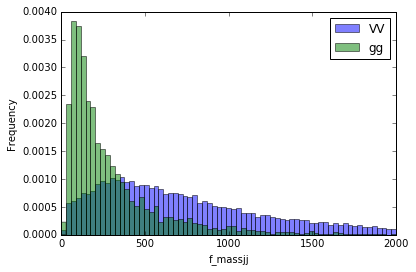

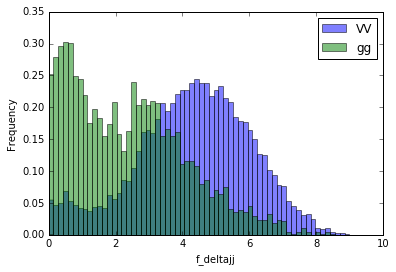

In [5]:
%matplotlib inline
plt.figure()
plt.xlabel(VARS[0])
bins = np.linspace(0, 2000, 70)
df['VV'][VARS[0]].plot.hist(bins, alpha=0.5, label='VV',normed=True)
df['gg'][VARS[0]].plot.hist(bins, alpha=0.5, label='gg',normed=True)
plt.legend(loc='upper right')
plt.figure()
plt.xlabel(VARS[1])
bins = np.linspace(0, 10, 70)
df['VV'][VARS[1]].plot.hist(bins, alpha=0.5, label='VV',normed=True)
df['gg'][VARS[1]].plot.hist(bins, alpha=0.5, label='gg',normed=True)
plt.legend(loc='upper right')

# Dense neural network
## Defining our model (neural net topology)
We'll start with a densely-connected NN layer. Our model will have a single fully connected hidden layer with the same number of neurons as input variables. The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to class values (0 or 1).

Finally, we are using the logarithmic loss function (`binary_crossentropy`) during training, a standard loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [6]:
# baseline model
NDIM = len(VARS)
def create_baseline():
    # This returns a tensor
    inputs = Input(shape=(NDIM,))    
    x = Dense(20, init='normal', activation='relu')(inputs)
    x = Dropout(0.20)(x)
    x = Dense(20, init='normal', activation='relu')(x)
    x = Dropout(0.20)(x)
    predictions = Dense(1, init='normal', activation='sigmoid')(x)
    # This creates a model that includes
    # the input layer and two dense layers (one output)
    model = Model(input=inputs, output=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_baseline()
model.summary()

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /uscms/homes/j/jduarte1/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.9-Ramsey-x86_64-2.7.11-64/tmpnmD3lQ/key.pkl


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 20)            60          input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 20)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 20)            420         dropout_1[0][0]                  
___________________________________________________________________________________________

## Dividing the data for cross validation
Now we can evaluate this model using stratified cross validation in the scikit-learn framework.

We will split the data into two parts (one for training and one for testing). We will also define our early stopping criteria to prevent over-fitting.

In [7]:
df_all = pd.concat([df['VV'],df['gg']])
dataset = df_all.values
X = dataset[:,0:NDIM].astype(float)
Y = dataset[:,NDIM]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Run training and visualize performance with ROC curves
Here, we run the training (twice) and visualize the performance of our model with a ROC curve for each cross validation sample.

Train on 9436 samples, validate on 9438 samples
Epoch 1/100
0s - loss: 0.3962 - acc: 0.8294 - val_loss: 0.3797 - val_acc: 0.8297
Epoch 2/100
0s - loss: 0.3940 - acc: 0.8298 - val_loss: 0.3948 - val_acc: 0.8297
Epoch 3/100
0s - loss: 0.3870 - acc: 0.8298 - val_loss: 0.3785 - val_acc: 0.8297
Epoch 4/100
1s - loss: 0.3870 - acc: 0.8298 - val_loss: 0.3782 - val_acc: 0.8297
Epoch 5/100
0s - loss: 0.3875 - acc: 0.8298 - val_loss: 0.3858 - val_acc: 0.8297
Epoch 6/100
0s - loss: 0.3872 - acc: 0.8298 - val_loss: 0.3805 - val_acc: 0.8297
Epoch 7/100
0s - loss: 0.3881 - acc: 0.8298 - val_loss: 0.3832 - val_acc: 0.8297
Epoch 8/100
0s - loss: 0.3868 - acc: 0.8298 - val_loss: 0.3780 - val_acc: 0.8297
Epoch 9/100
0s - loss: 0.3883 - acc: 0.8298 - val_loss: 0.3789 - val_acc: 0.8297
Epoch 10/100
0s - loss: 0.3859 - acc: 0.8298 - val_loss: 0.3994 - val_acc: 0.8297
Epoch 11/100
0s - loss: 0.3863 - acc: 0.8298 - val_loss: 0.3803 - val_acc: 0.8297
Epoch 12/100
0s - loss: 0.3895 - acc: 0.8298 - val_loss: 0.

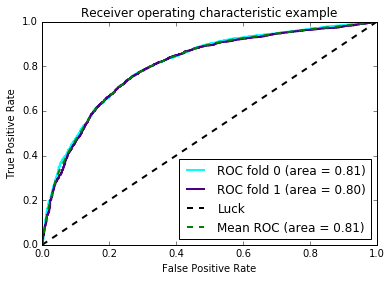

In [8]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    model = create_baseline()
    history = model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), nb_epoch=100, batch_size=32, verbose=2, callbacks=[early_stopping])
    Y_score = model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
df_all['dense'] = model.predict(X) # add prediction to array
print df_all.iloc[:5]

      f_massjj  f_deltajj  isSignal     dense
0  1300.426880   5.128572       1.0  0.961678
1   437.221863   3.278692       1.0  0.770428
3  1021.744080   5.989169       1.0  0.932337
4  1101.381958   5.170628       1.0  0.941299
7   498.717194   4.895020       1.0  0.802978


# Plotting inputs weighted by prediction
Let's see if we can shape the data distribution using the model weights and recover the ground truth

In [11]:
'''
HINT: 
Copy the example from "Plotting inputs" and use the weights=weights option of df.plot.hist
'''

'\nHINT: \nfollow the example from "Plotting inputs" and use the weights=weights option of df.plot.hist\n'

# Plot NN output vs input variables

In [14]:
'''
HINT: 
Think about what meshgrid is doing and what myZI should be to make
'''
myX = np.linspace(0, 7000, 70)
myY = np.linspace(0, 10, 70)
myXI, myYI = np.meshgrid(myX,myY)
myZI = np.array(myXI, copy=True)  
def predict(x, y):
    for i in range(0, len(x)):
        for j in range(0, len(x)):
            myZI[i,j] = 0 # change this 
    return myZI
myZI = predict(myXI, myYI)

In [ ]:
#from matplotlib.axes.Axes import set_xlim
plt.figure(figsize=(10,7))
plt.contourf(myXI,myYI,myZI, 200, cmap='PuOr')
plt.colorbar(boundaries=[0,1],label='NN output')
plt.contour(myXI,myYI,myZI, 3, levels=[0,0.5,1])
X = {}
X['VV'] = df['VV'].values[:,0:NDIM].astype(float)
X['gg'] = df['gg'].values[:,0:NDIM].astype(float)
plt.scatter(X['gg'][:,0],X['gg'][:,1],c='orange',alpha=0.3,s=10,marker="s",linewidths=0.2, edgecolor='white')
plt.scatter(X['VV'][:,0],X['VV'][:,1],c='purple',alpha=0.3,s=10,linewidths=0.2,edgecolor='white')
plt.xlim(0,7000)
plt.ylim(0,10)
plt.xlabel(VARS[0])
plt.ylabel(VARS[1])